# 天猫用户重复购买预测

**背景：** 识别哪些用户可能会成为重复购买其店铺商品的忠诚用户，以便对这些有潜力的忠诚用户进行精准营销，提高投资回报率。

**什么样的用户被定义为对店铺忠诚的用户：** 经常到某家店铺购买的用户就是该店铺的忠诚用户。

## 数据介绍

- 根据用户行为和画像信息，结合用户对店铺的复购标签来搭建模型。
- 建模过程主要根据用户的行为和画像信息来提取代表用户信息的相关统计特征，拟合用户复购的标签，从而预测这类新用户在未来一段时间内是否对该店铺产生复购行为。

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

user_log = pd.read_csv('user_log_format1.csv')
user_info = pd.read_csv('user_info_format1.csv')

In [2]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [3]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [4]:
from sklearn.metrics import roc_auc_score

y_true = np.array([0,0,1,1])
y_scores = np.array([0.1,0.4,0.35,0.8])
roc_auc_score(y_true, y_scores)

0.75

In [5]:
from sklearn.linear_model import LogisticRegression
x_train = np.array([[1,2,3],[1,3,4],[2,1,2],[4,5,6],[3,5,3],[1,7,2]])
y_train = np.array([0,0,0,1,1,1])

clf = LogisticRegression()
clf.fit(x_train,y_train)

x_test = np.array([[2,2,2],[3,2,6],[1,7,4]])

print(clf.predict(x_test))
print(clf.predict_proba(x_test))
print(clf.predict_log_proba(x_test))

[0 0 1]
[[0.87394275 0.12605725]
 [0.77045805 0.22954195]
 [0.07048027 0.92951973]]
[[-0.13474041 -2.07101914]
 [-0.26077007 -1.47166948]
 [-2.65242249 -0.07308724]]


## 数据特征抽取思路
- 从用户历史行为出发
- 从店铺历史行为出发
- 从用户和店铺的历史行为出发

## 数据探索

数据探索是解决实际场景问题最基本的步骤。
- 缺失值处理
- 样本不平衡
- 常见的数据分布

In [26]:
test_data = pd.read_csv('test_format1.csv')
train_data = pd.read_csv('train_format1.csv')

In [7]:
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [8]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [9]:
for data in [train_data,test_data,user_info,user_log]:
    print(f'{data.info()}')
    print('----')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB
None
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int64  
 1   merchant_id  261477 non-null  int64  
 2   prob         0 non-null       float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB
None
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421

In [10]:
(user_info.shape[0]-user_info['age_range'].count()) / user_info.shape[0]

0.005226677982884221

In [11]:
user_info[user_info['age_range'].isna() | user_info['age_range']==0].count()

user_id      92914
age_range    92914
gender       90638
dtype: int64

In [12]:
user_info.groupby(['age_range'])[['user_id']].count()

,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


In [13]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476178,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


In [14]:
label_gp = train_data.groupby('label')['user_id'].count()
print('正负样本的数量：%s'%label_gp)

正负样本的数量：label
0    244912
1     15952
Name: user_id, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

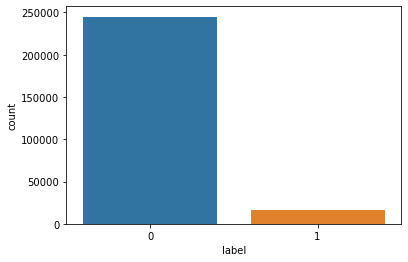

In [15]:
sns.countplot('label', data = train_data)

样本分布不平衡、需要采取一定的措施

In [16]:
print('选取top5店铺')
merchant_id_top5 = train_data.merchant_id.value_counts().head()
print(merchant_id_top5)

选取top5店铺
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64


In [17]:
train_data['merchant_id'].map(lambda x: 1 if x in list(merchant_id_top5.index) else 0)

0         0
1         0
2         0
3         0
4         0
         ..
260859    0
260860    0
260861    0
260862    0
260863    0
Name: merchant_id, Length: 260864, dtype: int64

## 特征工程

特征归一化的目的是消除数据特征之间的量纲影响、使不同指标之间具有可比性。

In [28]:
# reduce memory
def reduce_mem_usage(df, verbose = True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64','float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                df[col] = df[col].astype(np.float64)    

    end_mem = df.memory_usage().sum() / 1024**2
    print('memory_usage after optimization is:{:.2f}MB'.format(end_mem))
    print('descreased by {:.1f}%'.format(100*(start_mem-end_mem)/start_mem))

In [29]:
for data in [train_data,test_data,user_info,user_log]:
    data = reduce_mem_usage(data)

memory_usage after optimization is:1.74MB
descreased by 70.8%
memory_usage after optimization is:3.49MB
descreased by 41.7%
memory_usage after optimization is:3.24MB
descreased by 66.7%
memory_usage after optimization is:890.48MB
descreased by 69.6%


In [30]:
import gc
all_data = train_data.append(test_data)
all_data = all_data.merge(user_info, on='user_id',how='left')
del train_data,test_data,user_info

gc.collect()

30

In [32]:
user_log.sort_values(['user_id','time_stamp'],inplace=True)

In [35]:
def merge_list(df_id, join_columns,df_data,agg_dict,rename_dict):
    df_data = df_data.groupby(join_columns).\
                    agg(agg_dict).\
                    reset_index().\
                    rename(rename_dict)
    df_id = df_id.merge(df_data,on=join_columns,how='left')
    return df_id

list_join_func = lambda x: ' '.join(str(i) for i in x)
agg_dict = {
    'item_id':list_join_func,
    'cat_id':list_join_func,
    'seller_id':list_join_func,
    'brand_id':list_join_func,
    'time_stamp':list_join_func,
    'action_type':list_join_func
}

rename_dict = {
    'item_id':'item_path',
    'cat_id':'cat_path',
    'seller_id':'seller_path',
    'brand_id':'brand_path',
    'time_stamp':'time_stamp_path',
    'action_type':'action_type_path'
}
all_data = merge_list(all_data, 'user_id', user_log,agg_dict,rename_dict)

In [37]:
del user_log
gc.collect()

180

In [38]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float64
 3   prob         0 non-null       float64
 4   age_range    519763 non-null  float16
 5   gender       514796 non-null  float16
 6   item_id      522341 non-null  object 
 7   cat_id       522341 non-null  object 
 8   seller_id    522341 non-null  object 
 9   brand_id     522341 non-null  object 
 10  time_stamp   522341 non-null  object 
 11  action_type  522341 non-null  object 
dtypes: float16(2), float64(2), int16(1), int32(1), object(6)
memory usage: 40.8+ MB


### 提取统计特征